In [5]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pooch
import os
import tempfile
import pandas as pd
import s3fs
import boto3
import botocore
import datetime
import cartopy.crs as ccrs

import geopandas
import rioxarray
import xarray
from shapely.geometry import mapping

# import fiona
# import rasterio
# from cartopy.io.shapereader import Reader
# from cartopy.feature import ShapelyFeature
# import odc.geo.xr

/tmp/ipykernel_2317/2594324036.py:14: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas


In [6]:
import ipywidgets as widgets  # interactive display

%config InlineBackend.figure_format = 'retina'
plt.style.use(
    "https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle"
)

In [7]:
# @title Helper functions

def pooch_load(filelocation=None, filename=None, processor=None):
    shared_location = "/home/jovyan/shared/Data/tutorials/W1D3_RemoteSensingLandOceanandAtmosphere/noaa-cdr-precip-gpcp-monthly-pds/data"  # this is different for each day
    user_temp_cache = tempfile.gettempdir()

    if os.path.exists(os.path.join(shared_location, filename)):
        file = os.path.join(shared_location, filename)
    else:
        file = pooch.retrieve(
            filelocation,
            known_hash=None,
            fname=os.path.join(user_temp_cache, filename),
            processor=processor,
        )

    return file

In [8]:
def calculate_sdii_index(data):
    """
    This function calculates the Simple Daily Intensity Index (SDII), which
    represents the average amount of precipitation on wet days (days with
    precipitation greater than or equal to 1mm) for each year in the input data.
    The input data should be a Dataset with time coordinates, and the function
    returns a Dataset with the SDII index values for each year in the data.
    ----------
    - data (xarray.Dataset): Input dataset containing daily precipitation data.
    - period (str, optional): Period for which to calculate the SDII index.

    Returns:
    -------
        - xarray.Dataset: Dataset containing the SDII index for the given period.
    """
    # calculate daily precipitation amount on wet days (PR >= 1mm)
    wet_days = data.where(data >= 1)

    # group by year and calculate the sum precipitation on wet days
    sum_wet_days_grouped = wet_days.groupby("time.year").sum(dim="time")

    # count number of wet days for each time step
    w = wet_days.groupby("time.year").count(dim="time")

    # divide by the number of wet days to get SDII index
    sdii = sum_wet_days_grouped / w

    return sdii

In [9]:
def calculate_cdd_index(data):
    """
    This function takes a daily precipitation dataset as input and calculates
    the Consecutive Dry Days (CDD) index, which represents the longest sequence
    of consecutive days with precipitation less than 1mm. The input data should
    be a DataArray with time coordinates, and the function returns a DataArray
    with the CDD values for each unique year in the input data.
    Parameters:
    ----------
      - data (xarray.DataArray): The input daily precipitation data should be
      a dataset (eg. for chirps_data the SataArray would be chirps_data.precip)
    Returns:
    -------
      - cdd (xarray.DataArray): The calculated CDD index

    """
    # create a boolean array for dry days (PR < 1mm)
    dry_days = data < 1
    # initialize CDD array
    cdd = np.zeros(len(data.groupby("time.year")))
    # get unique years as a list
    unique_years = list(data.groupby("time.year").groups.keys())
    # iterate for each day
    for i, year in enumerate(unique_years):
        consecutive_trues = []
        current_count = 0
        for day in dry_days.sel(time=dry_days["time.year"] == year).values:
            if day.all():
                current_count += 1
            else:
                if current_count > 0:
                    consecutive_trues.append(current_count)
                    current_count = 0
        if current_count > 0:
            consecutive_trues.append(current_count)
        # print(consecutive_trues)
        # CDD is the largest number of consecutive days
        cdd[i] = np.max(consecutive_trues)
    # transform to dataset
    cdd_da = xr.DataArray(cdd, coords={"year": unique_years}, dims="year")
    return cdd_da

In [15]:
years=range(1951,2024) # the years you want. we want 1981 till 2023
file_paths=['/home/jovyan/shared/Data/tutorials/W1D3_RemoteSensingLandOceanandAtmosphere/noaa-cdr-precip-gpcp-monthly-pds/data/'+str(year)+'/gpcp_v02r03_monthly_*_c20170616.nc' for year in years] # the format of the files
filenames=[''+str(year)+'/gpcp_v02r03_monthly_*_c20170616.nc' for year in years] # the format of the files

downloaded_files=[ pooch_load(fpath,fname) for (fpath,fname) in zip(file_paths,filenames)] # download all of the files

#### open data as xarray
chirps_data = xr.open_mfdataset(
    downloaded_files, combine="by_coords"
)  # open the files as one dataset
#/home/jovyan/shared/Data/tutorials/W1D3_RemoteSensingLandOceanandAtmosphere/noaa-cdr-precip-gpcp-monthly-pds/data/1979/gpcp_v02r03_monthly_d197901_c20170616.nc

type: Unrecognized URL protocol 'file' in '/home/jovyan/shared/Data/tutorials/W1D3_RemoteSensingLandOceanandAtmosphere/noaa-cdr-precip-gpcp-monthly-pds/data/1951/gpcp_v02r03_monthly_*_c20170616.nc'. Must be one of dict_keys(['ftp', 'https', 'http', 'sftp', 'doi']).

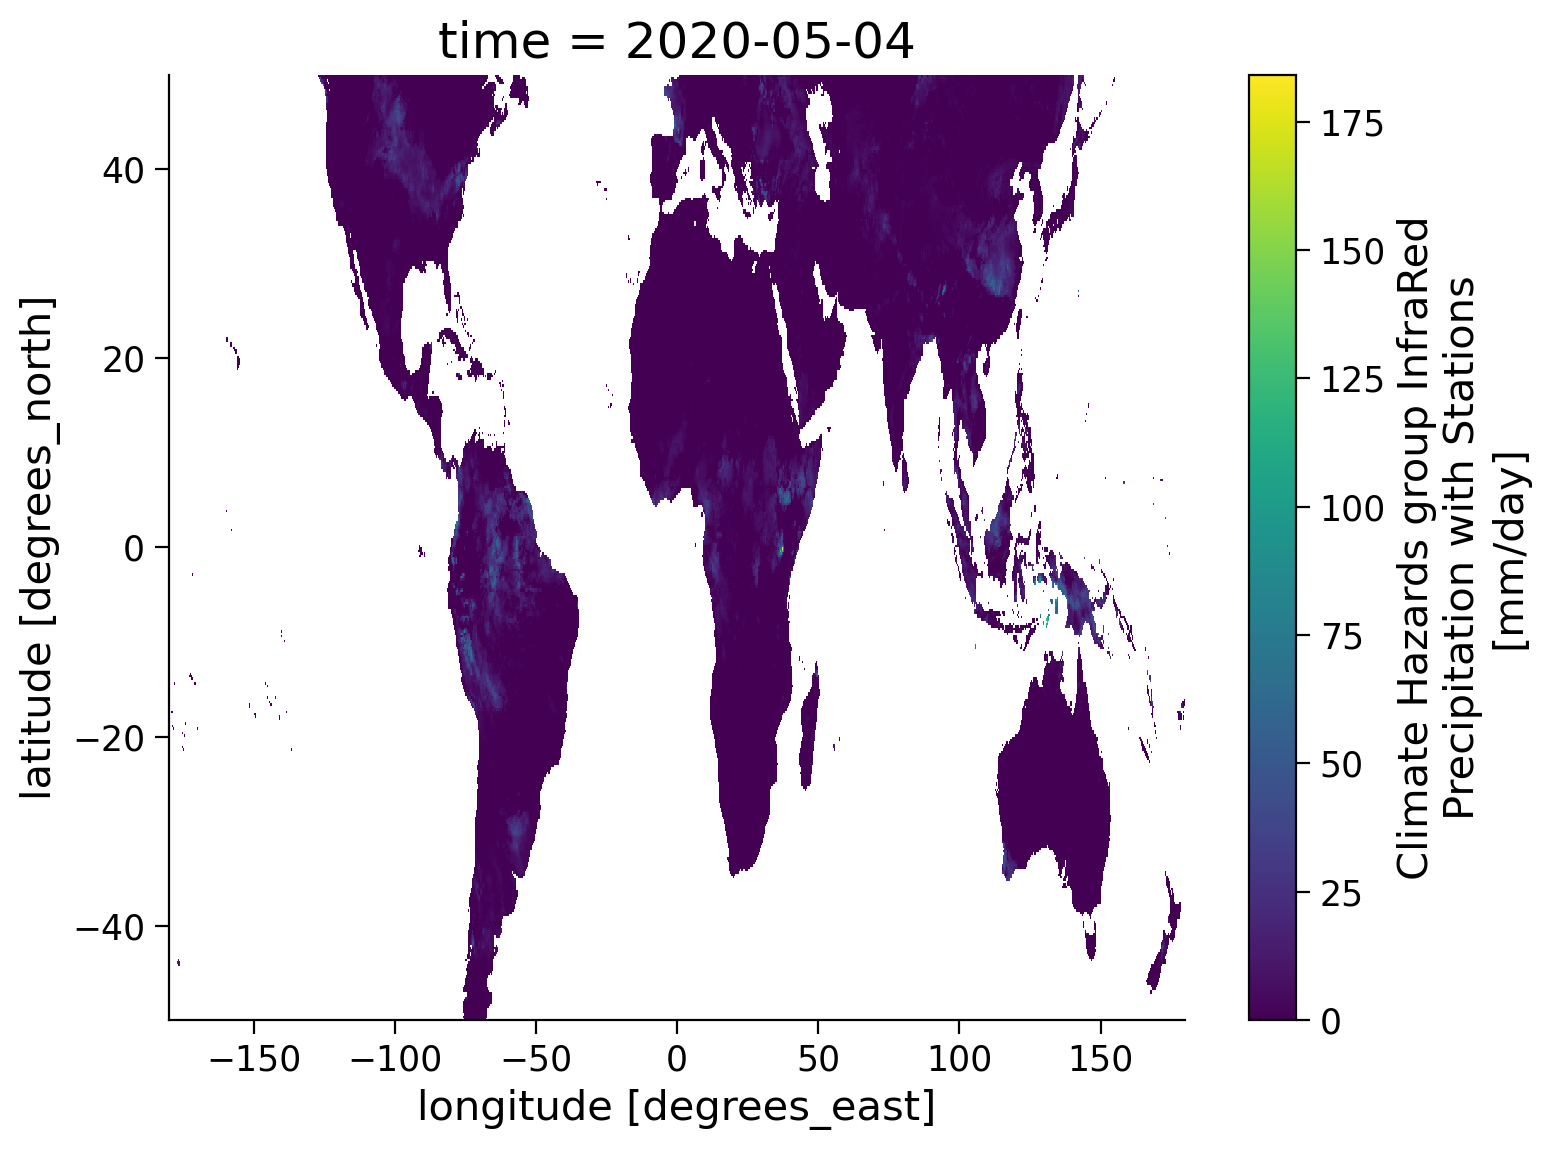

In [281]:
chirps_fig = chirps_data.sel(time = '2020-05-04')
chirps_fig.precip.plot.pcolormesh()

Text(0.5, 1.0, 'Map example')

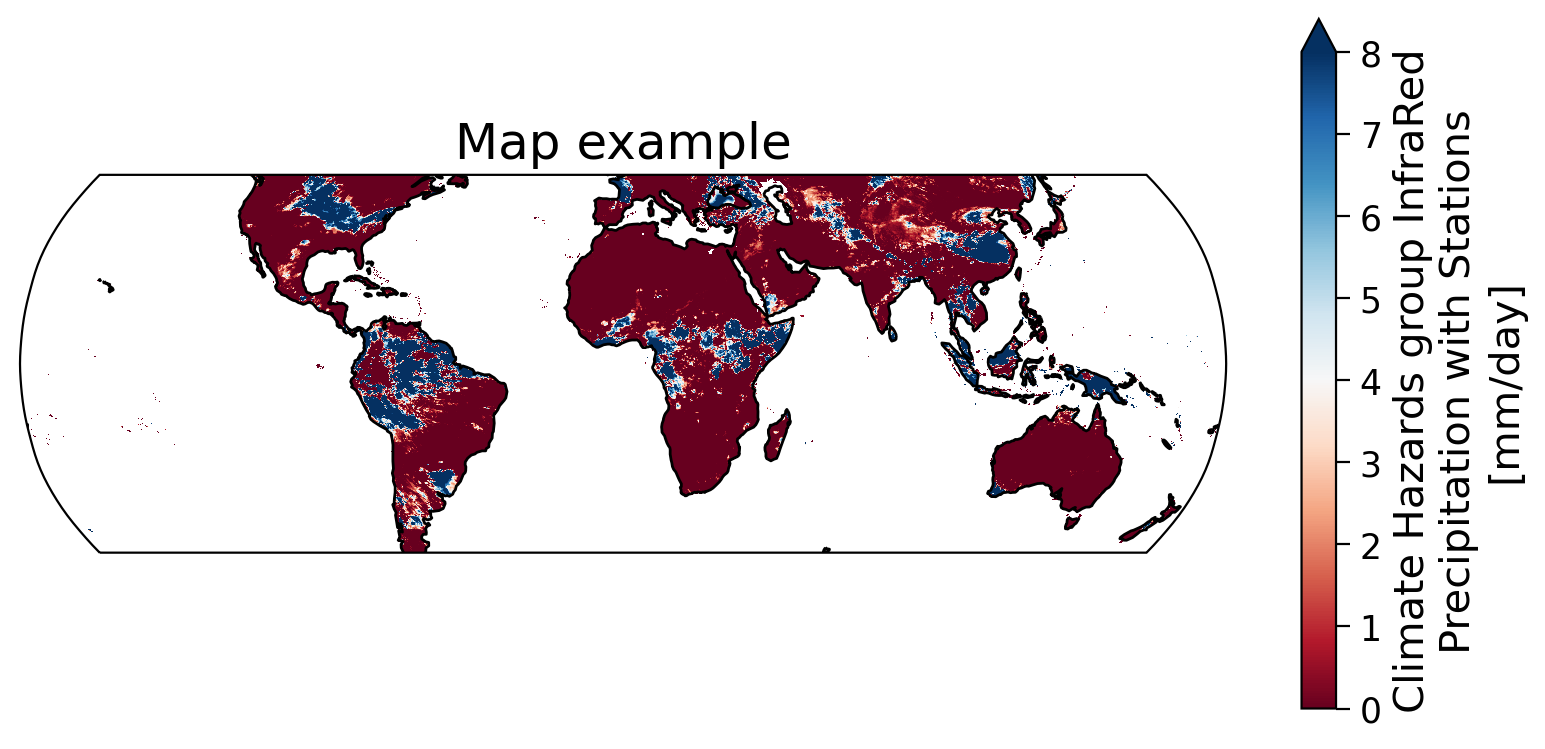

In [282]:
%matplotlib inline

fig, (ax_present) = plt.subplots(ncols=1, nrows=1, figsize=[8, 4], subplot_kw={"projection": ccrs.Robinson()})

chirps_fig = chirps_data.sel(time = '2020-05-04').precip.squeeze()

chirps_fig.plot(
    ax = ax_present,
    x = "longitude",
    y = "latitude",
    transform = ccrs.PlateCarree(),
    vmin = 0,
    vmax = 8,
    cmap = "RdBu",
    robust = True,
)
ax_present.coastlines()
ax_present.set_title("Map example")

In [283]:
chirps_year = chirps_data.groupby("time.year").sum(skipna = False)
da = chirps_year.mean(["longitude", "latitude"], keep_attrs = True)
da = da.precip.isel(year = slice(0, 99))
da

<xarray.DataArray 'precip' (year: 43)>
dask.array<mean_agg-aggregate, shape=(43,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 1981 1982 1983 1984 1985 ... 2019 2020 2021 2022 2023
Attributes:
    units:               mm/day
    standard_name:       convective precipitation rate
    long_name:           Climate Hazards group InfraRed Precipitation with St...
    time_step:           day
    geostatial_lat_min:  -50.0
    geostatial_lat_max:  50.0
    geostatial_lon_min:  -180.0
    geostatial_lon_max:  180.0

In [10]:
# Get shapefile with maize production in Mato Grosso do Sul (MS)
fname = "/home/jovyan/shared-public/Zuniceratops_Ska_Staccato/shp/China_Provinces.shp"
sf = geopandas.read_file(fname)
# sf.crs

In [17]:
chirps_year.rio.set_spatial_dims(x_dim = "longitude", y_dim = "latitude", inplace = True)
chirps_year.rio.write_crs("epsg:4674", inplace = True)
sf = geopandas.read_file(fname, crs = "epsg:4674")
clipped = chirps_year.rio.clip(sf.geometry.apply(mapping), sf.crs, drop = True, all_touched = True)

type: name 'chirps_year' is not defined

In [ ]:
import pandas
# google colab installs
# !pip install condacolab
# import condacolab
# condacolab.install()
# !mamba install xarray-datatree intake intake-esm gcsfs xmip aiohttp cartopy nc-time-axis cf_xarray xarrayutils "esmf<=8.3.1" xesmf

# imports and housekeeping
import time

tic = time.time()

import pandas as pd
import intake
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import xesmf as xe

from xmip.preprocessing import combined_preprocessing
from xarrayutils.plotting import shaded_line_plot

from datatree import DataTree
from xmip.postprocessing import _parse_metric

import cartopy.crs as ccrs
import random
import pooch
import os
import tempfile

import tqdm

# helper functions

def pooch_load(filelocation=None,filename=None,processor=None):
    shared_location='/home/jovyan/shared/Data/Projects/Heatwaves' # this is different for each day
    user_temp_cache=tempfile.gettempdir()
    
    if os.path.exists(os.path.join(shared_location,filename)):
        file = os.path.join(shared_location,filename)
    else:
        file = pooch.retrieve(filelocation,known_hash=None,fname=os.path.join(user_temp_cache,filename),processor=processor)

    return file

def global_mean(ds: xr.Dataset) -> xr.Dataset:
    """Global average, weighted by the cell area"""
    return ds.weighted(ds.areacello.fillna(0)).mean(["x", "y"], keep_attrs=True)

# @title Figure settings
import ipywidgets as widgets  # interactive display

%config InlineBackend.figure_format = 'retina'
plt.style.use(
    "https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle"
)
# model_colors = {k:f"C{ki}" for ki, k in enumerate(source_ids)}
%matplotlib inline

cities = pandas.read_csv('cn.csv')
cities


col = intake.open_esm_datastore(
    "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
)  # open an intake catalog containing the Pangeo CMIP cloud data

source_ids = ['ACCESS-CM2', 'ACCESS-ESM1-5', 'AWI-ESM-1-1-LR', 'BCC-CSM2-MR',
       'BCC-ESM1', 'CESM2', 'CESM2-FV2', 'CESM2-WACCM', 'CMCC-CM2-HR4',
       'CMCC-CM2-SR5', 'CMCC-ESM2', 'CanESM5', 'FGOALS-g3', 'ICON-ESM-LR',
       'IITM-ESM', 'MIROC6', 'MPI-ESM-1-2-HAM', 'MPI-ESM1-2-HR',
       'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NorCPM1', 'NorESM2-LM',
       'NorESM2-MM', 'SAM0-UNICON', 'TaiESM1']

# pick our five example models
# There are many more to test out! Try executing `col.df['source_id'].unique()` to get a list of all available models
source_ids = ["TaiESM1"]

cat = col.search(
    variable_id=["rsds", "rsus"],
    member_id="r1i1p1f1",
    grid_label="gn",
    source_id=source_ids,
    table_id='day',
    experiment_id=["historical", "ssp585"],  # add scenarios if interested in projection
    require_all_on=[
        "source_id", "experiment_id"],  # make sure that we only get models which have all of the above experiments
)

# # # convert the sub-catalog into a datatree object, by opening each dataset into an xarray.Dataset (without loading the data)
kwargs = dict(
    preprocess=combined_preprocessing,  # apply xMIP fixes to each dataset
    xarray_open_kwargs=dict(
        use_cftime=True
    ),  # ensure all datasets use the same time index
    storage_options={
        "token": "anon"
    },  # anonymous/public authentication to google cloud storage
)

cat.esmcat.aggregation_control.groupby_attrs = ["source_id", "experiment_id"]
dt = cat.to_datatree(**kwargs)

ds = dt["TaiESM1"]["historical"].to_dataset()
ds["alb"] = ds.rsus / (ds.rsds)
alb_diff = ds['alb'].sel(time='2014-12-28').squeeze() - ds['alb'].sel(time='1981-01-01').squeeze()

# da = clipped.precip.sel(year =2022) -clipped.precip.sel(year =1990)

ax = sf.plot(alpha = 0.8, color = 'black')
alb_diff.plot(ax = ax, alpha = 0.9)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'
